Entrainement des modèles qui serviront à l'analyse de nouvelles données (nouveau cas/nouveau NGS). Entraînement fait sur l'ensemble des données disponibles.

In [1]:
import os 
import pandas as pd
import numpy as np

In [2]:
# all file paths
from glob import glob
paths = glob(r"C:\Users\ahmed\MFE project\Final\**", recursive= True)

pathy = [i for i in paths if (len(i)>=120) & (i[-3:]!="pdf")]
pathy_amplicon = [i for i in pathy if i[-16:-8]=="amplicon"]

pathys = [i for i in paths if (i[-3:]!="pdf") & (len(i)>60) & (i.find("bcmatrix")<0)]
pathy_tsv = [i for i in pathys if i[-3:]=="tsv"]

In [3]:
#préparation du tsv

def extract_info_tsv(path):
    split = path.split('\\')
    annee = split[5]
    sp = split[6]
    spi = sp.replace('_', '-')
    spl = spi.split('-')
    type = 0
    date = 0
    num = 0
    if len(spl)==5:
        type = spl[0]
        date = '-'.join(spl[1:-1])
        num = spl[-1]
    if len(spl)==6:
        type = spl[0]
        date = spl[2]
        num = spl[-1]
    classe = split[7]
    return [annee, type, date, num, classe]

def create_TSV(pathy_tsv):
    caract = ["annee", "type", "date", "num", "classe"]
    df_list=[]
    for j in range(len(pathy_tsv)):
        path = pathy_tsv[j]
        dfa = pd.read_csv(path, sep='\t')
        if str(dfa["Barcode"][0])!="nan":
            df1 = dfa[dfa["Barcode"]==dfa["Barcode"][0]]
            df1.index = range(len(df1))
            cara = extract_info_tsv(path)
            for i in range(len(caract)):
                df1.loc[:,caract[i]]= cara[i]
            df1.loc[:,'ordre'] = j
            df1.loc[:,"longueur"] = len(df1)
            df_list.append(df1)
    df_tsv = pd.concat(df_list)
    df_tsv.index = range(len(df_tsv))
    df_tsv = df_tsv.replace("NAV", "NVA")
    df_tsv = df_tsv.replace("nva", "NVA")
    return df_tsv.fillna(0)
    
    #preparation du amplicon
def extract_info_amplicon(path):
    split = path.split('\\')
    annee = split[5]
    sp = split[6]
    spi = sp.replace('_', '-')
    spl = spi.split('-')
    type = 0
    date = 0
    num = 0
    if len(spl)==5:
        type = spl[0]
        date = '-'.join(spl[1:-1])
        num = spl[-1]
    if len(spl)==6:
        type = spl[0]
        date = spl[2]
        num = spl[-1]
    classe = split[7]
    num2 = split[-1].split('_')[1]
    num3 = split[-1].split('_')[-1][:-17]
    return [annee, type, date, num, classe, num2, num3]

def create_amplicon(pathy_amplicon):
    caract = ["annee", "type", "date", "num", "classe", "num2", "num3"]
    df_list=[]
    for j in range(len(pathy_amplicon)):
        path = pathy_amplicon[j]
        df1 = pd.read_csv(path, sep='\t')
        cara = extract_info_amplicon(path)
        for i in range(len(caract)):
            df1.loc[:,caract[i]]= cara[i]
        df1.loc[:,'ordre'] = j
        df1.loc[:, "longueur"] = len(df1)
        df_list.append(df1)
    df_amplicon = pd.concat(df_list)
    df_amplicon.index = range(len(df_amplicon))
    df_amplicon = df_amplicon.replace("NAV", "NVA")
    df_amplicon = df_amplicon.replace("nva", "NVA")
    df_amplicon.loc[:, "contig_length"] = df_amplicon["contig_end"] - df_amplicon["contig_srt"]+1
    df_amplicon.loc[:, "gc_percent"] = df_amplicon["gc_count"]/df_amplicon["contig_length"]
    df_amplicon.loc[:, "cov20_percent"] = df_amplicon["cov20x"]/df_amplicon["contig_length"]
    df_amplicon.loc[:, "cov100_percent"] = df_amplicon["cov100x"]/df_amplicon["contig_length"]
    df_amplicon.loc[:, "cov500_percent"] = df_amplicon["cov500x"]/df_amplicon["contig_length"]
    df_amplicon.loc[:, "fwd_e2e_percent"] = df_amplicon["fwd_e2e"]/df_amplicon["fwd_reads"]
    df_amplicon.loc[:, "rev_e2e_percent"] = df_amplicon["rev_e2e"]/df_amplicon["rev_reads"]
    return df_amplicon.fillna(0)

In [4]:
DF_tsv = create_TSV(pathy_tsv)
DF_amplicon = create_amplicon(pathy_amplicon)

C:\Users\ahmed\anaconda3\envs\myenv\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [5]:
#normaliser le train puis l'appliquer au test
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DF_tsv_norm = scaler.fit_transform(DF_tsv[["Frequency", "Quality", "Coverage", "Allele Cov", "longueur"]])
DF_tsv_norm = pd.concat([DF_tsv, pd.DataFrame(DF_tsv_norm, columns = ["Frequency_norm", "Quality_norm", "Coverage_norm", "Allele Cov_norm", "longueur_norm"])], axis = 1)

from sklearn.tree import DecisionTreeClassifier
DT =DecisionTreeClassifier(min_samples_leaf=17,max_depth= 10, min_samples_split= 9)

train_2class = DF_amplicon[(DF_amplicon["classe"]=="OPT")|(DF_amplicon["classe"]=="NC")]
New_var1 = ['gc_percent', 'cov500_percent', 'fwd_e2e_percent', 'rev_e2e_percent', 'cov20_percent', 'cov100_percent', 'contig_length']
DT.fit(train_2class[New_var1], train_2class["classe"])
pred = DT.predict(DF_amplicon[New_var1])
DF_amplicon.loc[:,"Pred2class"]=pred

from joblib import dump, load
# dump(scaler, "Scaler_final_erasme.joblib")
# dump(DT, "DT_final_erasme.joblib")

In [6]:
# des fonctions pour extraire les variables globales
def Extract_glob_feat(df, feat, longueur):
    nume = []
    nume.append(np.array([1 for i in df[feat].values if i>0.3]).sum()/longueur)
    nume.append(np.array([1 for i in df[feat].values if i>0.5]).sum()/longueur)
    nume.append(np.array([1 for i in df[feat].values if i>0.7]).sum()/longueur)
    nume.append(np.array([1 for i in df[feat].values if i>0.9]).sum()/longueur)
    df_res = pd.DataFrame(data = [[df[feat].mean(), df[feat].median(), nume[0], nume[1], nume[2], nume[3]]] , columns = [feat+"_mean", feat+"_median", feat+"_"+str(0.3), feat+"_"+str(0.5), feat+"_"+str(0.7), feat+"_"+str(0.9)])
    return df_res
    
def extract_all_var(df, variables, longueur):
    list_df = []
    for feat in variables:
        df_t = Extract_glob_feat(df, feat, longueur)
        list_df.append(df_t)
    df_tot = pd.concat(list_df, axis = 1)
    return df_tot

def create_var_glob_amplicon(df_amp):
    var_percent = ['gc_percent', 'cov20_percent', 'cov100_percent', 'cov500_percent', 'fwd_e2e_percent', 'rev_e2e_percent']
    ordr = list(dict.fromkeys(df_amp["ordre"].values))
    resultat = []

    for i in ordr:
        df_tru = df_amp[df_amp["ordre"]==i]
        longueur = df_tru["longueur"].values[0]
    # information des variables en pourcent
        df_var = extract_all_var(df_tru, var_percent, longueur)

    # information sur la classe
        df_var.loc[:,"ordre"] = i
        df_var.loc[:, "type"] = df_tru["type"].values[0]
        df_var.loc[:, "date"] = df_tru["date"].values[0]
        df_var.loc[:, "classe"] = df_tru["classe"].values[0]
        df_var.loc[:, "num2"] = df_tru["num2"].values[0]
        df_var.loc[:, "longueur"] = longueur

    # varible globale % de OPT
        OPT = np.array([1 for i in range(len(df_tru)) if df_tru["Pred2class"].values[i]=="OPT"]).sum()
        OPT_percent = OPT/longueur

        df_var.loc[:, "OPT_percent"] = OPT_percent

    # création de la base de données / CSV
        resultat.append(df_var)
    df_resul = pd.concat(resultat)
    df_resul.index = range(len(df_resul))
    return df_resul

def create_var_glob_tsv(df_tsv):
    var_percent = ['Frequency_norm', 'Quality_norm', 'Coverage_norm', 'Allele Cov_norm', 'longueur_norm']
    ordr = list(dict.fromkeys(df_tsv["ordre"].values))
    resultat = []

    for i in ordr:
        df_tru = df_tsv[df_tsv["ordre"]==i]
        longueur = df_tru["longueur"].values[0]
# information des variables en pourcent
        df_var = extract_all_var(df_tru, var_percent, longueur)

# création de la base de données / CSV
        resultat.append(df_var)
    df_resul = pd.concat(resultat)
    df_resul.index = range(len(df_resul))
    return df_resul

def create_var_glob_tot(df_amp, df_tsv):
    df_amp_glob = create_var_glob_amplicon(df_amp)
    df_tsv_glob = create_var_glob_tsv(df_tsv)
    df_global = pd.concat([df_amp_glob, df_tsv_glob], axis = 1)
    return df_global

In [14]:
# DF_tsv_norm = pd.concat([DF_tsv, pd.DataFrame(DF_tsv_norm, columns = ["Frequency_norm", "Quality_norm", "Coverage_norm", "Allele Cov_norm", "longueur_norm"])], axis = 1)

In [7]:
df = create_var_glob_tot(DF_amplicon, DF_tsv_norm)

<AxesSubplot:xlabel='classe', ylabel='Quality_norm_median'>

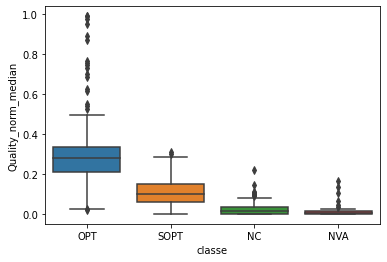

In [9]:
import seaborn as sns
sns.boxplot(data=df, y="Quality_norm_median", x="classe")

In [16]:
features = ['gc_percent_mean', 'gc_percent_median',
       'gc_percent_0.3', 'gc_percent_0.5', 'gc_percent_0.7', 'gc_percent_0.9',
       'cov20_percent_mean', 'cov20_percent_median', 'cov20_percent_0.3',
       'cov20_percent_0.5', 'cov20_percent_0.7', 'cov20_percent_0.9',
       'cov100_percent_mean', 'cov100_percent_median', 'cov100_percent_0.3',
       'cov100_percent_0.5', 'cov100_percent_0.7', 'cov100_percent_0.9',
       'cov500_percent_mean', 'cov500_percent_median', 'cov500_percent_0.3',
       'cov500_percent_0.5', 'cov500_percent_0.7', 'cov500_percent_0.9',
       'fwd_e2e_percent_mean', 'fwd_e2e_percent_median', 'fwd_e2e_percent_0.3',
       'fwd_e2e_percent_0.5', 'fwd_e2e_percent_0.7', 'fwd_e2e_percent_0.9',
       'rev_e2e_percent_mean', 'rev_e2e_percent_median', 'rev_e2e_percent_0.3',
       'rev_e2e_percent_0.5', 'rev_e2e_percent_0.7', 'rev_e2e_percent_0.9', 'longueur', 'OPT_percent',
       'Frequency_norm_mean', 'Frequency_norm_median', 'Frequency_norm_0.3',
       'Frequency_norm_0.5', 'Frequency_norm_0.7', 'Frequency_norm_0.9',
       'Quality_norm_mean', 'Quality_norm_median', 'Quality_norm_0.3',
       'Quality_norm_0.5', 'Quality_norm_0.7', 'Quality_norm_0.9',
       'Coverage_norm_mean', 'Coverage_norm_median', 'Coverage_norm_0.3',
       'Coverage_norm_0.5', 'Coverage_norm_0.7', 'Coverage_norm_0.9',
       'Allele Cov_norm_mean', 'Allele Cov_norm_median', 'Allele Cov_norm_0.3',
       'Allele Cov_norm_0.5', 'Allele Cov_norm_0.7', 'Allele Cov_norm_0.9',
       'longueur_norm_mean', 'longueur_norm_median', 'longueur_norm_0.3',
       'longueur_norm_0.5', 'longueur_norm_0.7', 'longueur_norm_0.9']

In [19]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators= 50)

RF.fit(df[features], df["classe"])

# dump(RF, "RF_final_erasme.joblib")

['RF_final_erasme.joblib']